In [19]:
from collections import defaultdict

import matplotlib.pyplot as plt
import networkx as nx
import os
import os.path
import sys
from pathlib import Path

from OCC.Core.GProp import GProp_GProps
from OCC.Core.STEPControl import STEPControl_Reader
from OCC.Core.IFSelect import IFSelect_RetDone, IFSelect_ItemsByEntity
from OCC.Core.GeomAbs import GeomAbs_Plane, GeomAbs_Cylinder, GeomAbs_NonUniform
from OCC.Core.TopAbs import TopAbs_FACE, TopAbs_EDGE, TopAbs_VERTEX
from OCC.Core.TopExp import TopExp_Explorer
from OCC.Core.TopoDS import topods, TopoDS_Face
from OCC.Core.BRepAdaptor import BRepAdaptor_Surface
from OCC.Display.SimpleGui import init_display
from OCC.Core.TopoDS import TopoDS_Shape
from OCC.Core.BRepAdaptor import BRepAdaptor_Surface, BRepAdaptor_Curve
from OCC.Core.GeomAbs import GeomAbs_Plane, GeomAbs_Cylinder, GeomAbs_Sphere, \
    GeomAbs_Cone, GeomAbs_BezierSurface, \
    GeomAbs_BSplineSurface, GeomAbs_OffsetSurface, \
    GeomAbs_SurfaceOfExtrusion, \
    GeomAbs_SurfaceOfRevolution
from OCC.Core import GeomAbs, TopExp
from OCC.Core.GeomAbs import GeomAbs_SurfaceType
import OCC.Core.BRepGProp as brp
from OCC.Core.GProp import GProp_GProps
from OCC.Core.BRep import BRep_Tool
from OCC.Core.BRepLProp import BRepLProp_SLProps

from OCC.Extend.TopologyUtils import TopologyExplorer

In [3]:
def read_step_file(filename):
    """read the STEP file and returns a compound"""
    step_reader = STEPControl_Reader()
    status = step_reader.ReadFile(filename)

    if status == IFSelect_RetDone:  # check status
        failsonly = False
        step_reader.PrintCheckLoad(failsonly, IFSelect_ItemsByEntity)
        step_reader.PrintCheckTransfer(failsonly, IFSelect_ItemsByEntity)
        step_reader.TransferRoot(1)
        a_shape = step_reader.Shape(1)
    else:
        print("Error: can't read file.")
        sys.exit(0)
    return a_shape

In [21]:
def get_face_properties(face):
    face_properties = {}
    surface = BRepAdaptor_Surface(face)
    surface_type = surface.GetType()
    edge_count = 0
    edge_explorer = TopExp_Explorer(face, TopAbs_EDGE)
    while edge_explorer.More():
        edge_count += 1
        edge_explorer.Next()

    vertex_count = 0
    vertex_explorer = TopExp_Explorer(face, TopAbs_VERTEX)
    while vertex_explorer.More():
        vertex_count += 1
        vertex_explorer.Next()
    props = GProp_GProps()
    brp.brepgprop.SurfaceProperties(face, props)
    u_min, u_max, v_min, v_max = surface.FirstUParameter(), surface.LastUParameter(), \
        surface.FirstVParameter(), surface.LastVParameter()
    u_span = u_max - u_min
    v_span = v_max - v_min
    u_mid = (u_min + u_max) / 2.0
    v_mid = (v_min + v_max) / 2.0
    geom_props = BRepLProp_SLProps(surface, 2, 1e-6)
    geom_props.SetParameters(u_mid, v_mid)
    mean_curvature = None
    gaussian_curvature = None
    if geom_props.IsCurvatureDefined():
        mean_curvature = geom_props.MeanCurvature()
        gaussian_curvature = geom_props.GaussianCurvature()
    face_properties = {
        "edge_count": edge_count,
        "vertex_count": vertex_count,
        "area" : props.Mass(),
        "u_span" : u_span,
        "v_span" : v_span,
        "mean_curvature" : mean_curvature,
        "gaussian_curvature" : gaussian_curvature,
        "orientation": face.Orientation(),
    }
    return face_properties

In [5]:
def parse_step_with_occ(step_file_path: Path or str):
    shape = read_step_file(step_file_path)

    # Parse all faces
    face_explorer = TopExp_Explorer(shape, TopAbs_FACE)
    edge_to_faces = defaultdict(list)
    face_list = []
    face_index = 0
    face_to_index = {}
    while face_explorer.More():
        face = face_explorer.Current()
        if face:
            face_list.append(face)
            face_to_index[face] = face_index
            face_index += 1
        face_explorer.Next()

    # Parse all edges for each face
    for face_idx, face in enumerate(face_list):
        edge_explorer = TopExp_Explorer(face, TopAbs_EDGE)
        while edge_explorer.More():
            edge = edge_explorer.Current()
            edge_hash = edge.__hash__()
            edge_to_faces[edge_hash].append((face_idx, edge))
            edge_explorer.Next()
    G = nx.Graph()
    for idx, face in enumerate(face_list):
        G.add_node(idx)
    shared_edges_info = []
    for edge_hash, face_list in edge_to_faces.items():
        if len(face_list) == 2:
            face1_idx, face1 = face_list[0]
            face2_idx, face2 = face_list[1]
            shared_edges_info.append((edge_hash, face1_idx, face2_idx))
            G.add_edge(face1_idx, face2_idx, edge_hash=edge_hash, shared_edge_count=len(face_list))
        if len(face_list) >= 2:
            for i in range(len(face_list)):
                for j in range(i + 1, len(face_list)):
                    face1_idx, face1 = face_list[i]
                    face2_idx, face2 = face_list[j]
                    shared_edges_info.append((edge_hash, face1_idx, face2_idx))
                    G.add_edge(face1_idx, face2_idx, edge_hash=edge_hash,shared_edge_count = len(face_list))
    return G

In [11]:
shp = read_step_file(r"C:\Users\ManhPhan.AzureAD\Downloads\square_pocket.step")

In [12]:
t = TopologyExplorer(shp)

In [13]:
all_faces = list(t.faces())
all_edges = list(t.edges())
all_vertices = list(t.vertices())
len(all_faces), len(all_edges), len(all_vertices)

(11, 24, 16)

In [33]:
face_explorer = TopExp_Explorer(shp, TopAbs_FACE)
edge_to_faces = defaultdict(list)
face_list = []
face_index = 0
face_to_index = {}
while face_explorer.More():
    face = face_explorer.Current()
    if face:
        face_list.append(face)
        face_to_index[face] = face_index
        face_index += 1
    face_explorer.Next()

In [35]:
for face_idx, face in enumerate(face_list):
    edge_explorer = TopExp_Explorer(face, TopAbs_EDGE)
    while edge_explorer.More():
        edge = edge_explorer.Current()
        edge_hash = edge.__hash__()
        edge_to_faces[edge_hash].append((face_idx, edge))
        edge_explorer.Next()

In [48]:
edge_to_faces

defaultdict(list,
            {6525178723372063888: [(0, <class 'TopoDS_Edge'>),
              (1, <class 'TopoDS_Edge'>)],
             4577556143123394228: [(0, <class 'TopoDS_Edge'>),
              (4, <class 'TopoDS_Edge'>)],
             2625177178679756922: [(0, <class 'TopoDS_Edge'>),
              (2, <class 'TopoDS_Edge'>)],
             2080118660258349705: [(0, <class 'TopoDS_Edge'>),
              (3, <class 'TopoDS_Edge'>)],
             14410038910103509559: [(1, <class 'TopoDS_Edge'>),
              (5, <class 'TopoDS_Edge'>)],
             5276238884587265063: [(1, <class 'TopoDS_Edge'>),
              (4, <class 'TopoDS_Edge'>)],
             3803995984709164926: [(1, <class 'TopoDS_Edge'>),
              (3, <class 'TopoDS_Edge'>)],
             880930479518315574: [(2, <class 'TopoDS_Edge'>),
              (4, <class 'TopoDS_Edge'>)],
             12433910935932515832: [(2, <class 'TopoDS_Edge'>),
              (5, <class 'TopoDS_Edge'>)],
             98521809361226

In [109]:
G = nx.Graph()
for idx, face in enumerate(face_list):
    G.add_node(idx)
shared_edges_info = []
for edge_hash, face_list in edge_to_faces.items():
    if len(face_list) == 2:
        face1_idx, face1 = face_list[0]
        face2_idx, face2 = face_list[1]
        shared_edges_info.append((edge_hash, face1_idx, face2_idx))
        G.add_edge(face1_idx, face2_idx, edge_hash=edge_hash, shared_edge_count=len(face_list))
    if len(face_list) >= 2:
        for i in range(len(face_list)):
            for j in range(i + 1, len(face_list)):
                face1_idx, face1 = face_list[i]
                face2_idx, face2 = face_list[j]
                shared_edges_info.append((edge_hash, face1_idx, face2_idx))
                G.add_edge(face1_idx, face2_idx, edge_hash=edge_hash, shared_edge_count = len(face_list))

In [106]:
G.nodes[0]

{'face': "(9, <class 'TopoDS_Edge'>)"}

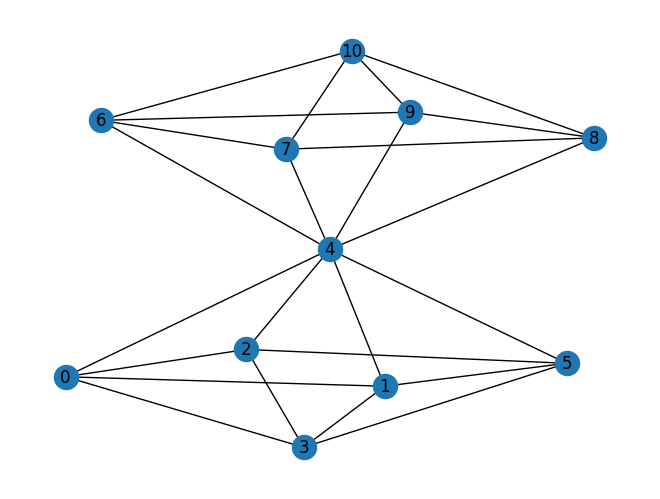

In [107]:
nx.draw(G, with_labels=True)

In [108]:
# save graph as graphml format
custom_names = {
    'edge_hash': 'edge_hash',
    'shared_faces_count': 'number_of_shared_faces'
}
# nx.write_graphml(G, r"C:\test_graphml.graphml", custom_names)
nx.write_graphml_lxml(G, r"C:\test_graphml.graphml", prettyprint=True)

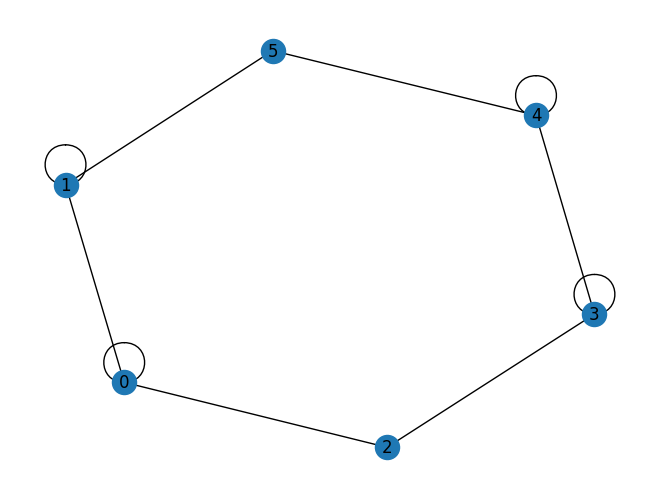

In [7]:
step_path = r"C:\step_files\70794_DOC_RSG00000547_____ipt.stp"
G2 = parse_step_with_occ(step_path)
nx.draw(G2, with_labels=True)
nx.write_graphml(G2, r"C:\70794_DOC_RSG00000547_____ipt.graphml", prettyprint=True)

In [22]:
shp = read_step_file(step_path)
t = TopologyExplorer(shp)
for face in t.faces():
    print(get_face_properties(face))
    break

2 - 283.2337873075959 - 6.283185307179586, 2.1213203435596433 - -0.016637806616154067 - -0.0
{'edge_count': 4, 'vertex_count': 8, 'area': 283.2337873075959, 'u_span': 6.283185307179586, 'v_span': 2.1213203435596433, 'mean_curvature': -0.016637806616154067, 'gaussian_curvature': -0.0, 'orientation': 0}


In [9]:
import networkx as nx

G = nx.Graph()
face_ids = {}
counter = 0

In [18]:
from OCC.Core.BRepAdaptor import BRepAdaptor_Surface
from OCC.Core.GeomAbs import GeomAbs_SurfaceType
import OCC.Core.BRepGProp as brp
from OCC.Core.GProp import GProp_GProps
from OCC.Core.GeomLProp import GeomLProp_SLProps
from OCC.Core.GeomLProp import GeomLProp_SLProps
from OCC.Core.BRep import BRep_Tool
from OCC.Core.BRepLProp import BRepLProp_SLProps

for face in all_faces:
    surface = BRepAdaptor_Surface(face)
    surface_type = surface.GetType()
    edge_count = 0
    edge_explorer = TopExp_Explorer(face, TopAbs_EDGE)
    while edge_explorer.More():
        edge_count += 1
        edge_explorer.Next()

    vertex_count = 0
    vertex_explorer = TopExp_Explorer(face, TopAbs_VERTEX)
    while vertex_explorer.More():
        vertex_count += 1
        vertex_explorer.Next()
    props = GProp_GProps()
    brp.brepgprop.SurfaceProperties(face, props)
    u_min, u_max, v_min, v_max = surface.FirstUParameter(), surface.LastUParameter(), \
        surface.FirstVParameter(), surface.LastVParameter()
    u_span = u_max - u_min
    v_span = v_max - v_min
    u_mid = (u_min + u_max) / 2.0
    v_mid = (v_min + v_max) / 2.0
    geom_props = BRepLProp_SLProps(surface, 2, 1e-6)
    geom_props.SetParameters(u_mid, v_mid)
    mean_curvature = 0
    gaussian_curvature = 0
    if geom_props.IsCurvatureDefined():
        mean_curvature = geom_props.MeanCurvature()
        gaussian_curvature = geom_props.GaussianCurvature()
    print(f"{surface_type} - {props.Mass()} - {u_span}, {v_span} - {mean_curvature} - {gaussian_curvature} - {face.Orientation()}")


0 - 2336.7609899999993 - 77.892033, 30.0 - 0.0 - 0.0 - 1
0 - 4696.658009999999 - 156.55526700000001, 30.0 - 0.0 - 0.0 - 1
0 - 4696.658009999999 - 156.55526700000001, 30.0 - 0.0 - 0.0 - 1
0 - 12194.408023487807 - 156.55526700000001, 77.892033 - 0.0 - 0.0 - 1
0 - 9325.27542396891 - 156.55526700000001, 77.892033 - 0.0 - 0.0 - 0
0 - 2336.7609899999993 - 77.892033, 30.0 - 0.0 - 0.0 - 1
0 - 172.23649999999998 - 34.4473, 5.0 - 0.0 - 0.0 - 1
0 - 416.45246499999996 - 83.290493, 5.0 - 0.0 - 0.0 - 1
0 - 172.23649999999998 - 34.4473, 5.0 - 0.0 - 0.0 - 1
0 - 416.45246499999996 - 83.290493, 5.0 - 0.0 - 0.0 - 1
0 - 2869.1325995189 - 83.290493, 34.4473 - 0.0 - 0.0 - 0


In [42]:
import OCC.Core.GeomAbs as Geom

for item in dir(Geom):
    if not item.startswith("__") and item.startswith("Geom"):
        attr = getattr(Geom, item)
        print(f"{item} = {attr}")

GeomAbs_Arc = 0
GeomAbs_BSplKnotDistribution = <enum 'GeomAbs_BSplKnotDistribution'>
GeomAbs_BSplineCurve = 6
GeomAbs_BSplineSurface = 6
GeomAbs_BezierCurve = 5
GeomAbs_BezierSurface = 5
GeomAbs_C0 = 0
GeomAbs_C1 = 2
GeomAbs_C2 = 4
GeomAbs_C3 = 5
GeomAbs_CN = 6
GeomAbs_Circle = 1
GeomAbs_Cone = 2
GeomAbs_CurveType = <enum 'GeomAbs_CurveType'>
GeomAbs_Cylinder = 1
GeomAbs_Ellipse = 2
GeomAbs_G1 = 1
GeomAbs_G2 = 3
GeomAbs_Hyperbola = 3
GeomAbs_Intersection = 2
GeomAbs_IsoType = <enum 'GeomAbs_IsoType'>
GeomAbs_IsoU = 0
GeomAbs_IsoV = 1
GeomAbs_JoinType = <enum 'GeomAbs_JoinType'>
GeomAbs_Line = 0
GeomAbs_NonUniform = 0
GeomAbs_NoneIso = 2
GeomAbs_OffsetCurve = 7
GeomAbs_OffsetSurface = 9
GeomAbs_OtherCurve = 8
GeomAbs_OtherSurface = 10
GeomAbs_Parabola = 4
GeomAbs_PiecewiseBezier = 3
GeomAbs_Plane = 0
GeomAbs_QuasiUniform = 2
GeomAbs_Shape = <enum 'GeomAbs_Shape'>
GeomAbs_Sphere = 3
GeomAbs_SurfaceOfExtrusion = 8
GeomAbs_SurfaceOfRevolution = 7
GeomAbs_SurfaceType = <enum 'GeomAbs_Surfac

In [19]:
u_min, u_max, v_min, v_max = surface.FirstUParameter(), surface.LastUParameter(), \
    surface.FirstVParameter(), surface.LastVParameter()

In [20]:
u_min, u_max, v_min, v_max

(-41.6452465, 41.6452465, -17.22365, 17.22365)

In [61]:
import OCC.Core.BRepAdaptor as bra

OCC.Core.BRepAdaptor.BRepAdaptor_Surface